In [4]:
import numpy as np
import pandas as pd


import os

import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.applications import Xception
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D
from keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model,Sequential
from tensorflow.keras.layers import Input

In [5]:
IMAGE_SIZE = 80
COLORS=3
BATCH_SIZE = 64
RANDOM_STATE=42

In [6]:
classification_types=['Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
                      'Potato___Early_blight','Potato___Late_blight','Potato___healthy',
                      'Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight',
                      'Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot',
                      'Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot',
                      'Tomato__Tomato_YellowLeaf__Curl_Virus',
                      'Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = 'PlantVillage/'
train_dir = os.path.join(data_dir)
print(train_dir)

PlantVillage/


In [7]:
train_data=[]
for id, disease in enumerate(classification_types):
    dir = os.path.join(data_dir,disease)
    for file in os.listdir(dir):
        train_data.append([os.path.join(disease,file),id,disease,os.path.join(dir,file)])


train = pd.DataFrame(train_data,columns=['File','DiseaseID','Disease_Type','File_Path'])
train.head()

,File,DiseaseID,Disease_Type,File_Path
0,Pepper__bell___Bacterial_spot\0022d6b7-d47c-4e...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\002...
1,Pepper__bell___Bacterial_spot\006adb74-934f-44...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\006...
2,Pepper__bell___Bacterial_spot\00f2e69a-1e56-41...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\00f...
3,Pepper__bell___Bacterial_spot\01613cd0-d3cd-4e...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\016...
4,Pepper__bell___Bacterial_spot\0169b9ac-07b9-4b...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\016...


In [8]:
train = train.sample(frac=1,random_state=RANDOM_STATE)
train.reset_index(drop=True, inplace=True)
train.head()

,File,DiseaseID,Disease_Type,File_Path
0,Tomato_healthy\9d197d8a-3f35-401a-8aa4-39f7e69...,14,Tomato_healthy,PlantVillage/Tomato_healthy\9d197d8a-3f35-401a...
1,Potato___Early_blight\900514b4-8768-4370-bc53-...,2,Potato___Early_blight,PlantVillage/Potato___Early_blight\900514b4-87...
2,Tomato_Septoria_leaf_spot\dc5f2f7d-8b86-402e-8...,9,Tomato_Septoria_leaf_spot,PlantVillage/Tomato_Septoria_leaf_spot\dc5f2f7...
3,Tomato_healthy\e3b5600f-9c88-4060-826f-aa7c972...,14,Tomato_healthy,PlantVillage/Tomato_healthy\e3b5600f-9c88-4060...
4,Tomato_Leaf_Mold\2e84cbfc-af2c-4c2b-9273-84275...,8,Tomato_Leaf_Mold,PlantVillage/Tomato_Leaf_Mold\2e84cbfc-af2c-4c...


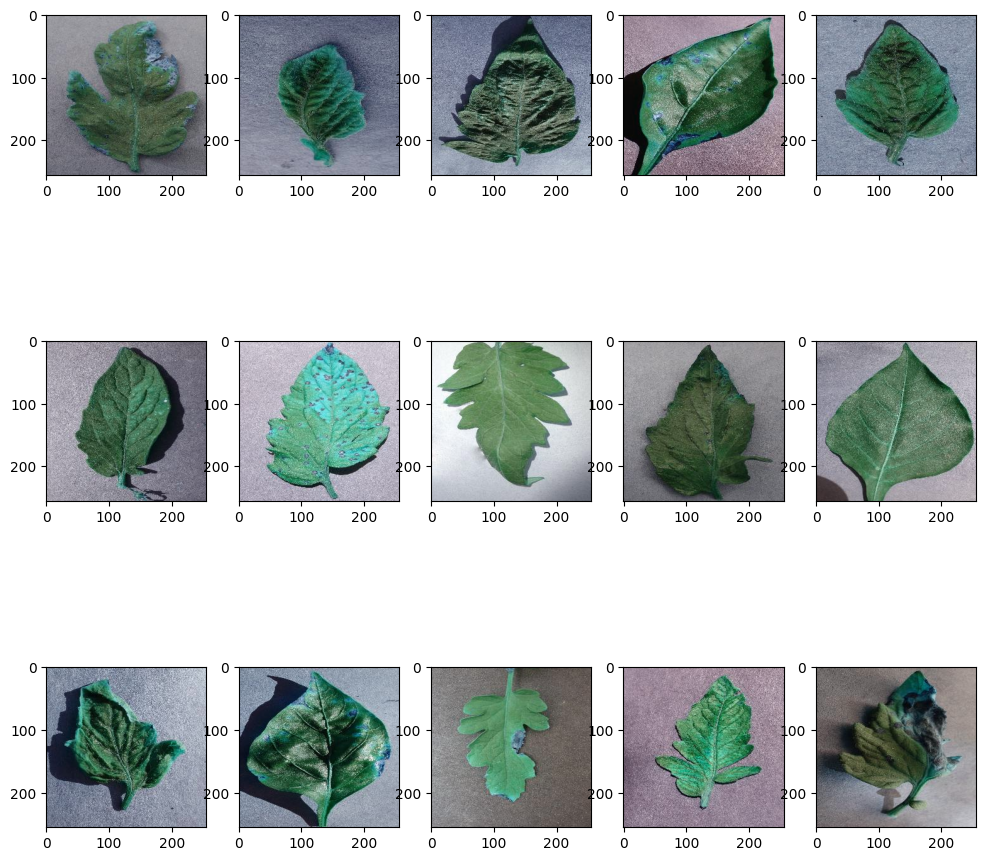

In [9]:
def display_random_images(rows,cols):
    fig, ax = plt.subplots(rows,cols,figsize=(12,12))
    random = train.sample(rows*cols)

    for i in range(rows):
        for j in range(cols):
            image_path=os.path.join(data_dir,random.iloc[i*cols+j]['File'])
            ax[i,j].imshow(cv2.imread(image_path))

display_random_images(3,5)

In [10]:
def get_training_data():
    data = np.zeros((train.shape[0],IMAGE_SIZE,IMAGE_SIZE,COLORS))
    for i, file in tqdm(enumerate(train['File'].values)):
        img = cv2.imread(os.path.join(data_dir,file))
        if img is not None:
            img_resized = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
            img_resized = img_resized/255
            data[i]=img_resized
    return data

X = get_training_data()

20639it [00:23, 895.99it/s]


In [11]:
X.shape

(20639, 80, 80, 3)

In [12]:
y = to_categorical(train['DiseaseID'],num_classes=np.unique(train['DiseaseID']).size)
print(y.shape)

(20639, 15)


In [16]:
def image_dataset_from_dataframe(df, image_column, label_column, **kwargs):
    def decode_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
        return image, label
    paths = df[image_column].values
    labels = df[label_column].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(kwargs.get('batch_size', 32))
    return dataset

In [17]:
train_ds = image_dataset_from_dataframe(train,'File_Path','Disease_Type',batch_size=32)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Found 41276 files belonging to 16 classes.
Using 4127 files for validation.


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)

In [19]:
X_train.shape

(16511, 80, 80, 3)

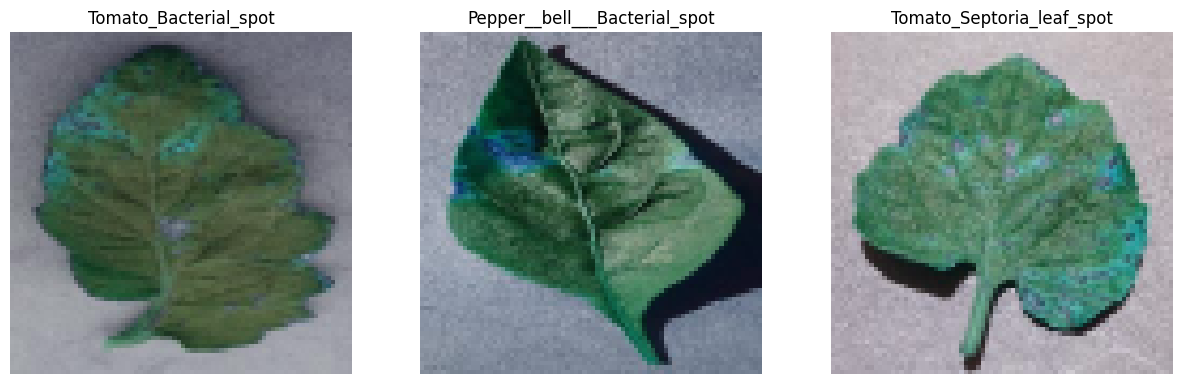

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(classification_types[np.argmax(y_train[i])])

In [21]:
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically
datagen.fit(X_train)

In [22]:
base_model=Xception(weights='imagenet',include_top=False,pooling='avg',
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,COLORS))
base_model.trainable=False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step
